In [1]:
import PolyBin3D as pb  # the main code
import numpy as np
import h5py
import matplotlib.pyplot as plt

from astropy.cosmology import Planck18 as cosmo

In [56]:
filename = '/anvil/scratch/x-mho1/cmass-ili/mtnglike/fastpm/L3000-N384/88/halos.h5'
a = '0.666660'
with h5py.File(filename, 'r') as f:
    pos, vel = f[a]['pos'][:], f[a]['vel'][:]

In [57]:

import redshift_space_library as RSL
import MAS_library as MASL


def MA(pos, L, N, MAS='CIC'):
    pos = np.ascontiguousarray(pos)
    delta = np.zeros((N, N, N), dtype=np.float32)
    pos %= L
    MASL.MA(pos, delta, BoxSize=L, MAS=MAS)
    delta = delta.astype(np.float64)
    delta /= np.mean(delta)
    delta -= 1
    return delta


def MAz(pos, vel, L, N, cosmo, z, MAS='CIC', axis=0):
    pos, vel = map(np.ascontiguousarray, (pos, vel))
    RSL.pos_redshift_space(pos, vel, L, cosmo.H(z).value/cosmo.h, z, axis)
    return MA(pos, L, N, MAS)

In [58]:
Lbox = 3000
Nbox = 384
MAS = 'TSC'
# field = MA(pos, Lbox, Nbox, MAS)
field = MAz(pos, vel, Lbox, Nbox, cosmo, 0.5, MAS, axis=2)

In [59]:
# # Define fiducial power spectrum (assuming the Kaiser formula)
# k_arr = np.arange(0.001, 1., 0.001)
# Plin_arr = Plin(k_arr)
# P0_arr = (b1**2 + 2./3.*b1*fz + 1./5.*fz**2.)*Plin_arr+1./nbar
# P2_arr = (4./3.*b1*fz + 4./7.*fz**2.)*Plin_arr
# P4_arr = 8./35.*fz**2*Plin_arr
# Pk_theory = [k_arr, P0_arr, P2_arr, P4_arr]

# # Define weighting, only using the monopole
# Pk_fiducial = [k_arr, P0_arr]
boxsize = [Lbox]*3  # size of the simulation volume
gridsize = [Nbox]*3  # grid size for computing the density field

# Load the PolyBin3D class using the fiducial power spectrum
base = pb.PolyBin3D(
    boxsize, gridsize, None,
    boxcenter=[0]*3,  # center of the simulation volume
    pixel_window=MAS.lower(),  # pixel window function
    # backend for performing FFTs ('mkl' or 'fftw' for cpu, 'jax' for gpu)
    backend='fftw',
    # number of CPUs for performing FFTs (does not apply to jax computations)
    nthreads=31,
    # line-of-sight [global = z-axis, local = relative to pair]
    sightline='global',
)


# Dimensions: [3.00e+03, 3.00e+03, 3.00e+03] Mpc/h
# Center: [0.00e+00, 0.00e+00, 0.00e+00] Mpc/h
# Line-of-sight: global


# Cartesian grid: [384, 384, 384]
# Fundamental frequency: [0.0021, 0.0021, 0.0021] h/Mpc
# Nyquist frequency: [0.402, 0.402, 0.402] h/Mpc
# Pixel window: tsc
# Using FFTW backend


In [63]:
# Define some k-bins and ell_max
k_edges = np.arange(0.01, 0.4, 0.01)
lmax = 4

# Load the power spectrum class
pspec = pb.PSpec(base, k_edges, lmax=lmax, applySinv=None, mask=None)


Binning: 38 bins in [0.010, 0.390] h/Mpc
l-max: 4
Mask: constant


In [64]:
pk = pspec.Pk_ideal(field, discreteness_correction=True)

# Define the k-bin centers
k_cen = pspec.get_ks()

# Print number of FFTs used for diagnostics
print("\nComputations complete using %d forward and %d reverse FFTs" %
      (base.n_FFTs_forward, base.n_FFTs_reverse))

Computing ideal Fisher matrix



Computations complete using 2 forward and 0 reverse FFTs


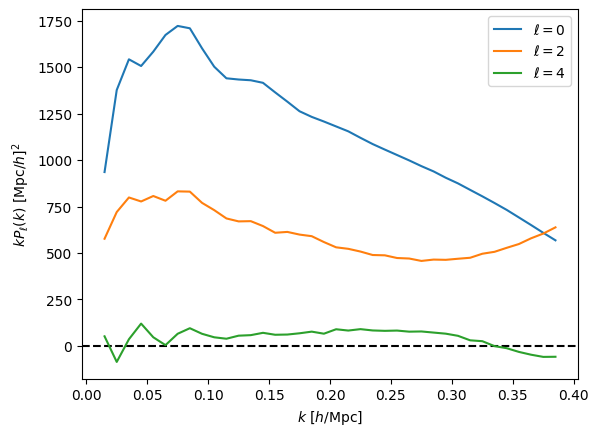

In [65]:
plt.axhline(0, color='k', ls='--')
for ell in range(0, 3):
    ell *= 2
    plt.plot(k_cen, k_cen*pk[f'p{ell}'], label=f'$\ell={ell}$')
plt.xlabel(r'$k\ [h/\mathrm{Mpc}]$')
plt.ylabel(r'$k P_\ell(k)\ [\mathrm{Mpc}/h]^2$')
plt.legend()

In [50]:
2*np.pi/Lbox

0.0020943951023931952

In [ ]:


# Define some k-bins and ell_max
k_edges = np.arange(0.01, 0.20, 0.03)
# add extra high-k bins for squeezed triangles
k_edges_squeeze = np.arange(0.01, 0.2, 0.03)
lmax = 2

# Load the bispectrum class
bspec = pb.BSpec(
    base,
    k_edges,  # one-dimensional bin edges
    # weighting function [only used in unwindowed estimators]
    applySinv=None,
    mask=None,  # real-space mask
    lmax=lmax,  # maximum Legendre multipole
    k_bins_squeeze=k_edges_squeeze,  # squeezed bins
    # whether to include bins whose centers do not satisfy triangle conditions
    include_partial_triangles=False,
    # use the same P_fid as the base class. If Pk_fid = None, we don't apply any weighting.
    Pk_fid='default',
)


Binning: 6 bins in [0.010, 0.190] h/Mpc
Squezed binning: 6 bins in [0.010, 0.190] h/Mpc
l-max: 2
N_bins: 68
Mask: constant


Text(0, 0.5, '$k_i$')

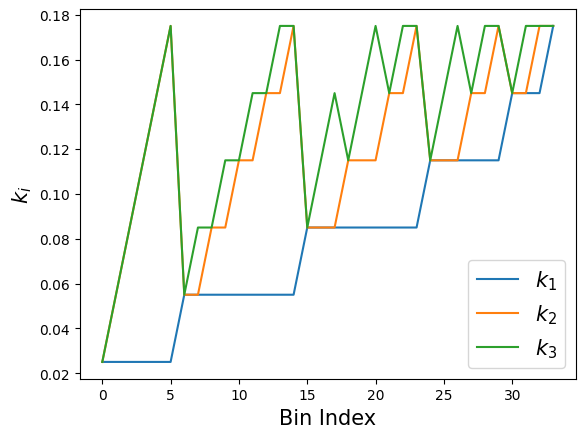

In [47]:
# Plot k-bins
k123 = bspec.get_ks()
for i in range(3):
    plt.plot(k123[i], label=r'$k_%d$' % (i+1))
plt.legend(fontsize=15)
plt.xlabel(r'Bin Index', fontsize=15)
plt.ylabel(r'$k_i$', fontsize=15)

In [ ]:
# Compute the ideal bispectrum with and without the discretess correction
bk_corr = bspec.Bk_ideal(field, discreteness_correction=True)
bk_uncorr = bspec.Bk_ideal(field, discreteness_correction=False)

# Print number of FFTs used for diagnostics
print("\nComputations complete using %d forward and %d reverse FFTs" %
      (base.n_FFTs_forward, base.n_FFTs_reverse))

Computing degeneracy factor


Computing ideal Fisher matrix
Computing ideal Fisher matrix

Computations complete using 5 forward and 240 reverse FFTs


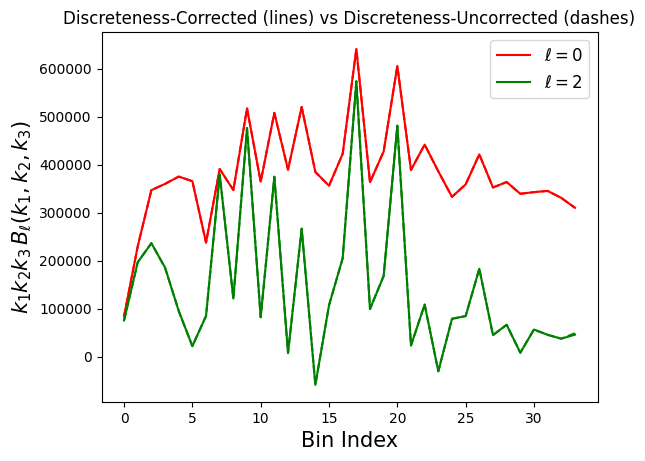

In [ ]:
cs = ['r', 'g']
weight = k123.prod(axis=0)
for l in range(0, lmax+1, 2):
    plt.plot(weight*bk_corr['b%d' % l], c=cs[l//2], label=r'$\ell=%d$' % l)
    plt.plot(weight*bk_uncorr['b%d' % l], c=cs[l//2], ls='--')
plt.xlabel(r'Bin Index', fontsize=15)
plt.ylabel(r'$k_1k_2k_3\,B_\ell(k_1,k_2,k_3)$', fontsize=15)
plt.legend(fontsize=12)
plt.title(
    'Discreteness-Corrected (lines) vs Discreteness-Uncorrected (dashes)', fontsize=12)

Computing ideal Fisher matrix


Computing ideal Fisher matrix


NameError: name 'plot_corr' is not defined

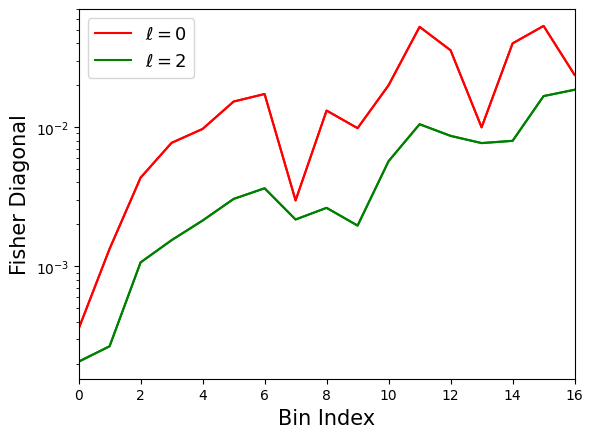

In [ ]:
# (Re)compute the ideal Fisher matrix with and without the discretess correction
fish_ideal_corr = bspec.compute_fisher_ideal(discreteness_correction=True)
fish_ideal_uncorr = bspec.compute_fisher_ideal(discreteness_correction=False)

for l in range(0, lmax+1, 2):
    plt.plot(np.diag(fish_ideal_corr)[
             l//2*bspec.N3:(l//2+1)*bspec.N3], c=cs[l//2], label=r'$\ell=%d$' % l)
    plt.plot(np.diag(fish_ideal_uncorr)[
             l//2*bspec.N3:(l//2+1)*bspec.N3], c=cs[l//2])
plt.xlabel(r'Bin Index', fontsize=15)
plt.ylabel(r'Fisher Diagonal', fontsize=15)
plt.legend(fontsize=13)
plt.yscale('log')
plt.xlim(0, bspec.N3-1)

# Plot correlation matrix
plot_corr(fish_ideal_corr, subtract_identity=False,
          v=1e-7, title='With Correction')
plot_corr(fish_ideal_uncorr, subtract_identity=False,
          v=1e-7, title='Without Correction')